# Bayesian Machine Learning
## Challenges in Markov chain Monte Carlo for Bayesian neural networks

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from typing import Union
from tqdm import tqdm

sys.path.append('../source/')
from HMC import HMC
from MALA import MALA, AdaptiveMALA
from RWHM import Metropolis_Hastings
from model import Model

In [2]:
seed = 42
torch.random.manual_seed(seed)
np.random.seed(seed)

### Utils

In [3]:
def log_target_factory(
        mlp: Model,
        X: Union[np.ndarray, torch.Tensor],
        y: Union[np.ndarray, torch.Tensor],
    ):

    def log_target_fn(theta):
        log_target_tensor = mlp.compute_log_target(X, y, theta)
        log_target_array = log_target_tensor.cpu().detach().numpy()
        return log_target_array
        
    return log_target_fn

In [4]:
def grad_log_target_factory(
        mlp: Model,
        X: Union[np.ndarray, torch.Tensor],
        y: Union[np.ndarray, torch.Tensor],
    ):

    def grad_log_target_fn(theta):
        log_target_tensor = mlp.compute_log_target(X, y, theta)
        grad_tensor = mlp.compute_grad_log_target(log_target_tensor)
        grad_array = grad_tensor.cpu().detach().numpy()
        return grad_array

    return grad_log_target_fn

In [5]:
def predict(
        mlp: Model,
        X: Union[np.ndarray, torch.Tensor],
        y: Union[np.ndarray, torch.Tensor],
        parameters_chain: Union[np.ndarray, torch.Tensor],
        return_probas: bool=False
    ):
    n_samples = len(y)
    n_classes = mlp.sizes[-1]

    y_pred = np.zeros(n_samples, dtype=int)
    y_probas = np.zeros((n_samples, n_classes))

    for i, X_i in tqdm(enumerate(X)):
        ret_i = mlp.predict(
            X_i.reshape((1, -1)),
            parameters_chain,
            return_probas=return_probas
        )

        y_proba_i = None
        if return_probas:
            y_pred_i, y_proba_i = ret_i
        else:
            y_pred_i = ret_i

        y_pred_i = y_pred_i.cpu().detach().numpy().flatten()
        y_pred[i] = y_pred_i[0]

        if y_proba_i is not None:
            y_proba_i = y_proba_i.cpu().detach().numpy().flatten()
            y_probas[i] = y_proba_i

    ret = [y_pred]
    if return_probas:
        ret += [y_probas]
    
    return tuple(ret)

In [6]:
def run(
    sizes,
    activations,
    X_train,
    y_train,
    X_test,
    y_test,
    N_steps=110_000,
    N_burnin=10_000,
    verbose=False,
    mh_params=dict(sigma_prop=None),
    hmc_params=dict(step_size=0.00004, n_leapfrog=10),
    mala_params=dict(step_size=None),
    sala_params=dict(step_size=None),
    n_params_to_plot=2,
):
    samples_to_consider = (N_steps - N_burnin) // 10
    

    plot, n_lines, n_columns = False, 1, 1
    if n_params_to_plot > 0:
        n_columns = 4
        n_lines = (n_params_to_plot // n_columns) + int(n_params_to_plot % n_columns != 0)
        plot = True

    def do_plot(title, sample):
        if not plot:
            return
        plt.figure(figsize=(5*n_columns, 5*n_lines))
        plt.title(title)
        for i in range(n_params_to_plot):
            plt.subplot(n_lines, n_columns, i+1)
            plt.plot(sample[:, i], label=f"$\theta_{i}$")
        plt.show()
    
    mlp = Model(sizes, activations)
    print(mlp)

    log_target_fn = log_target_factory(mlp, X_train, y_train)
    grad_log_target_fn = log_target_factory(mlp, X_train, y_train)

    N_params = mlp.num_parameters()
    mu = np.zeros(N_params)
    sigma =  10 * np.ones(N_params)
    def prior(size):
        return np.random.multivariate_normal(mean=mu, cov=np.diag(sigma), size=size)
    
    theta_0 = prior(1)[0]
    
    print("_Prior_Sampling_".center(100).replace(" ", "=").replace("_", " "))
    sample = prior(samples_to_consider)
    do_plot("Prior Sampling", sample)
    y_pred, y_probas = predict(
        mlp, X_test, y_test, parameters_chain=sample, return_probas=True
    )
    print("\tAccuracy: ", accuracy_score(y_test, y_pred))
    
    print("_Hamiltonian_Monte_Carlo_".center(100).replace(" ", "=").replace("_", " "))
    HMC_sampler = HMC(
        log_target=log_target_fn, grad_log_target=grad_log_target_fn, theta_0=theta_0, **hmc_params
    )
    sample_HMC, acc_HMC = HMC_sampler.sample(N_steps, N_burnin, verbose=verbose)
    do_plot("Hamiltonian Monte Carlo", sample_HMC)
    print("\tAcceptance rate: ", acc_HMC)
    y_pred, y_probas = predict(
        mlp, X_test, y_test, parameters_chain=sample_HMC[N_steps-samples_to_consider::], return_probas=True
    )
    print("\tAccuracy: ", accuracy_score(y_test, y_pred))
    
    print("_Adapative_MALA_".center(100).replace(" ", "=").replace("_", " "))
    SALA_sampler = AdaptiveMALA(
        log_target=log_target_fn, grad_log_target=grad_log_target_fn, theta_0=theta_0, **sala_params
    )
    sample_SALA, acc_SALA = SALA_sampler.sample(N_steps, N_burnin, verbose=verbose)
    do_plot("Adaptive MALA", sample_SALA)
    print("\tAcceptance rate: ", acc_SALA)
    y_pred, y_probas = predict(
        mlp, X_test, y_test, parameters_chain=sample_SALA[N_steps-samples_to_consider::], return_probas=True
    )
    print("\tAccuracy: ", accuracy_score(y_test, y_pred))

    print("_MALA_".center(100).replace(" ", "=").replace("_", " "))
    if mala_params["step_size"] is None:
        mala_params["step_size"] =np.square(0.004*np.power(N_params, -0.33))
    MALA_sampler = MALA(
        log_target=log_target_fn, grad_log_target=grad_log_target_fn, theta_0=theta_0, **mala_params
    )
    sample_MALA, acc_MALA = MALA_sampler.sample(N_steps, N_burnin, verbose=verbose)
    do_plot("MALA", sample_MALA)
    print("\tAcceptance rate: ", acc_MALA)
    y_pred, y_probas = predict(
        mlp, X_test, y_test, parameters_chain=sample_MALA[N_steps-samples_to_consider::], return_probas=True
    )
    print("\tAccuracy: ", accuracy_score(y_test, y_pred))
    
    print("_Symmetric_Random_Walk_Metropolis_Hastings_".center(100).replace(" ", "=").replace("_", " "))
    MH_sampler = Metropolis_Hastings(
        log_target=log_target_fn, theta_0=theta_0, **mh_params
    )
    sample_MH , acc_MH = MH_sampler.sample(N_steps,N_burnin, verbose=verbose)
    do_plot("Metropolis Hastings", sample_MH)
    print("\tAcceptance rate: ", acc_MH)
    y_pred, y_probas = predict(
        mlp, X_test, y_test, parameters_chain=sample_MH[N_steps-samples_to_consider::], return_probas=True
    )
    print("\tAccuracy: ", accuracy_score(y_test, y_pred))
    

### Noisy XOR

In [7]:
sizes_xor = [2, 2, 2]
activations_xor = [nn.ReLU(), nn.ReLU(), None]

#### Dataset 1

In [8]:
X_noisy_xor_1 = pd.read_csv("../data/noisy_xor/data1/training/x.csv")
Y_noisy_xor_1 = pd.read_csv("../data/noisy_xor/data1/training/y.csv")
X_noisy_xor_1 = X_noisy_xor_1.to_numpy()
Y_noisy_xor_1 = Y_noisy_xor_1.to_numpy(dtype=int).flatten()
X_noisy_xor_1_test = pd.read_csv("../data/noisy_xor/data1/test/x.csv")
Y_noisy_xor_1_test = pd.read_csv("../data/noisy_xor/data1/test/y.csv")
X_noisy_xor_1_test = X_noisy_xor_1_test.to_numpy()
Y_noisy_xor_1_test = Y_noisy_xor_1_test.to_numpy(dtype=int).flatten()

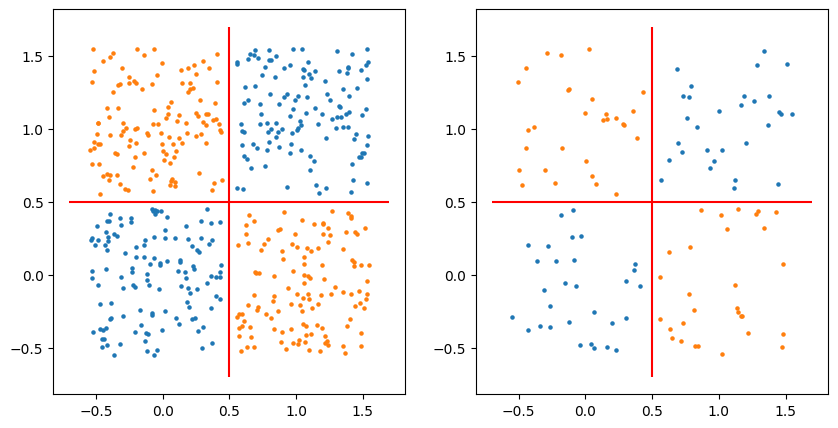

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_noisy_xor_1[Y_noisy_xor_1==0, 0], X_noisy_xor_1[Y_noisy_xor_1==0, 1], s=5)
plt.scatter(X_noisy_xor_1[Y_noisy_xor_1==1, 0], X_noisy_xor_1[Y_noisy_xor_1==1, 1], s=5)
plt.vlines(x=0.5, ymin=-0.7, ymax=1.7, color="r")
plt.hlines(y=0.5, xmin=-0.7, xmax=1.7, color="r")

plt.subplot(1, 2, 2)
plt.scatter(X_noisy_xor_1_test[Y_noisy_xor_1_test==0, 0], X_noisy_xor_1_test[Y_noisy_xor_1_test==0, 1], s=5)
plt.scatter(X_noisy_xor_1_test[Y_noisy_xor_1_test==1, 0], X_noisy_xor_1_test[Y_noisy_xor_1_test==1, 1], s=5)
plt.vlines(x=0.5, ymin=-0.7, ymax=1.7, color="r")
plt.hlines(y=0.5, xmin=-0.7, xmax=1.7, color="r")

plt.show()

Model(
  (layers): ModuleList(
    (0-1): 2 x Linear(in_features=2, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)
========================================== Prior Sampling ==========================================


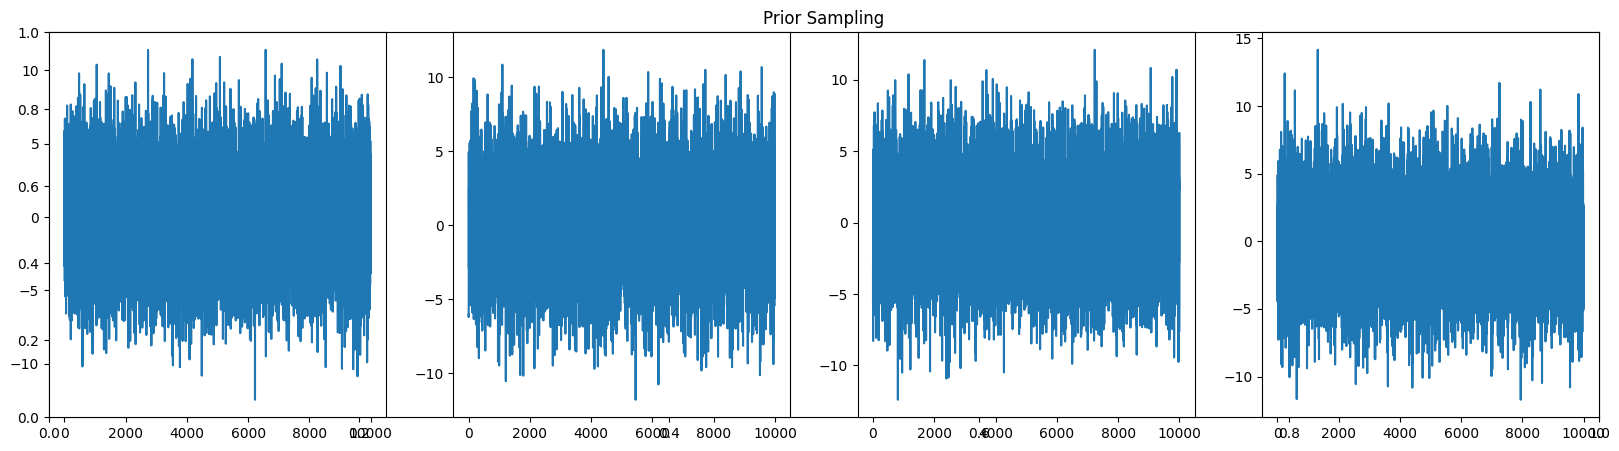

0it [00:00, ?it/s]

120it [06:38,  3.32s/it]


	Accuracy:  0.5166666666666667
===================================== Hamiltonian Monte Carlo ======================================


100%|██████████| 110000/110000 [11:34<00:00, 158.32it/s]


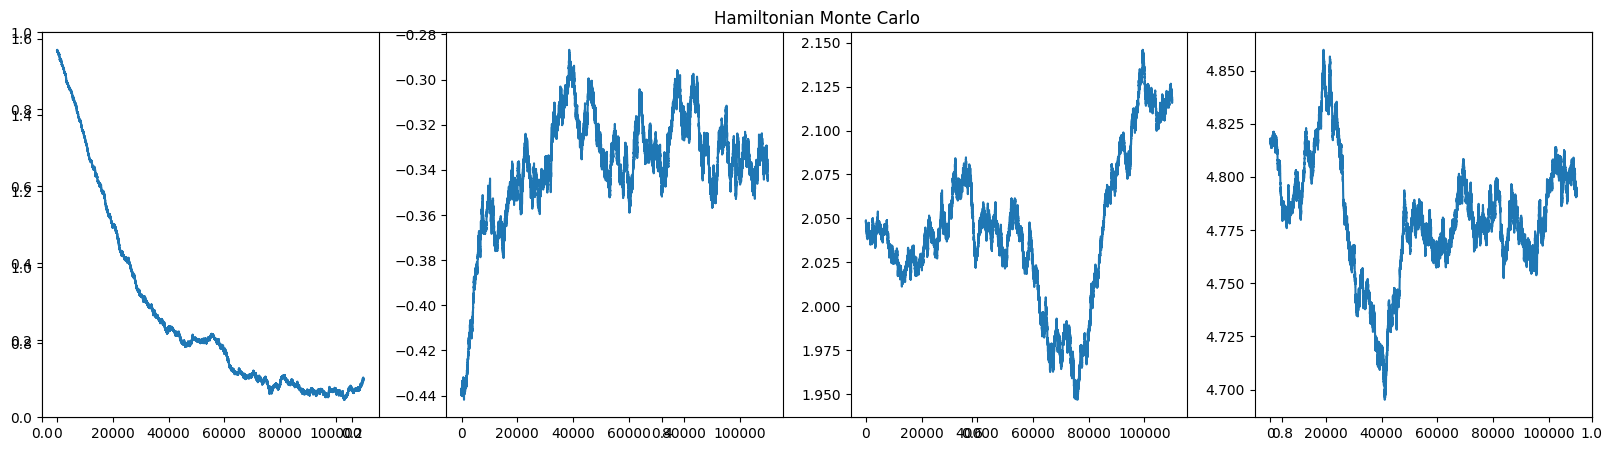

	Acceptance rate:  0.7492


120it [06:41,  3.35s/it]


	Accuracy:  0.6833333333333333
========================================== Adapative MALA ==========================================


100%|██████████| 110000/110000 [03:35<00:00, 510.05it/s]


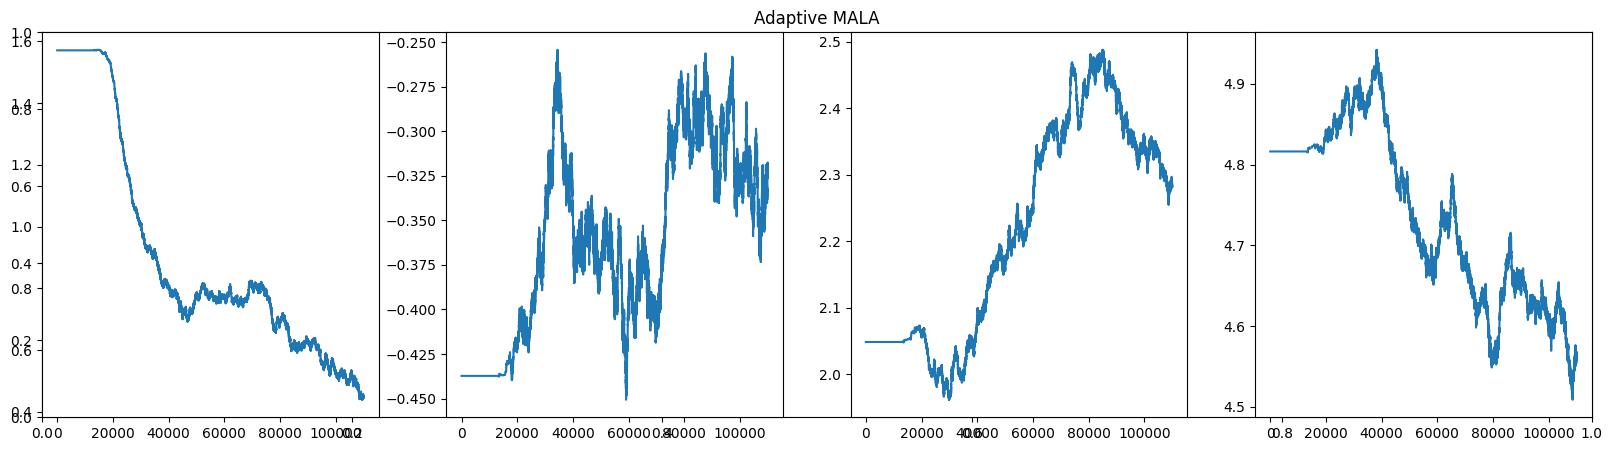

	Acceptance rate:  0.46445454545454545


120it [06:42,  3.36s/it]


	Accuracy:  0.7666666666666667
=============================================== MALA ===============================================
Running MALA sampler...


100%|██████████| 110000/110000 [04:29<00:00, 407.71it/s]


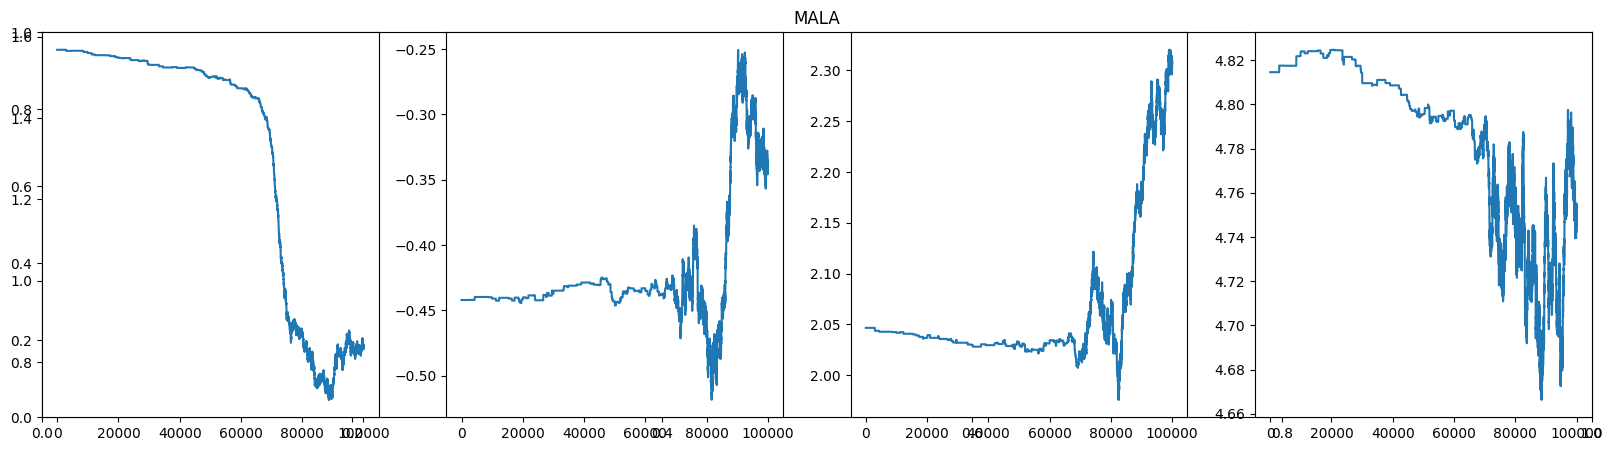

	Acceptance rate:  0.07156363636363636


120it [00:00, 1878.61it/s]


	Accuracy:  0.7
============================ Symmetric Random Walk Metropolis Hastings =============================


100%|██████████| 110000/110000 [01:46<00:00, 1033.70it/s]


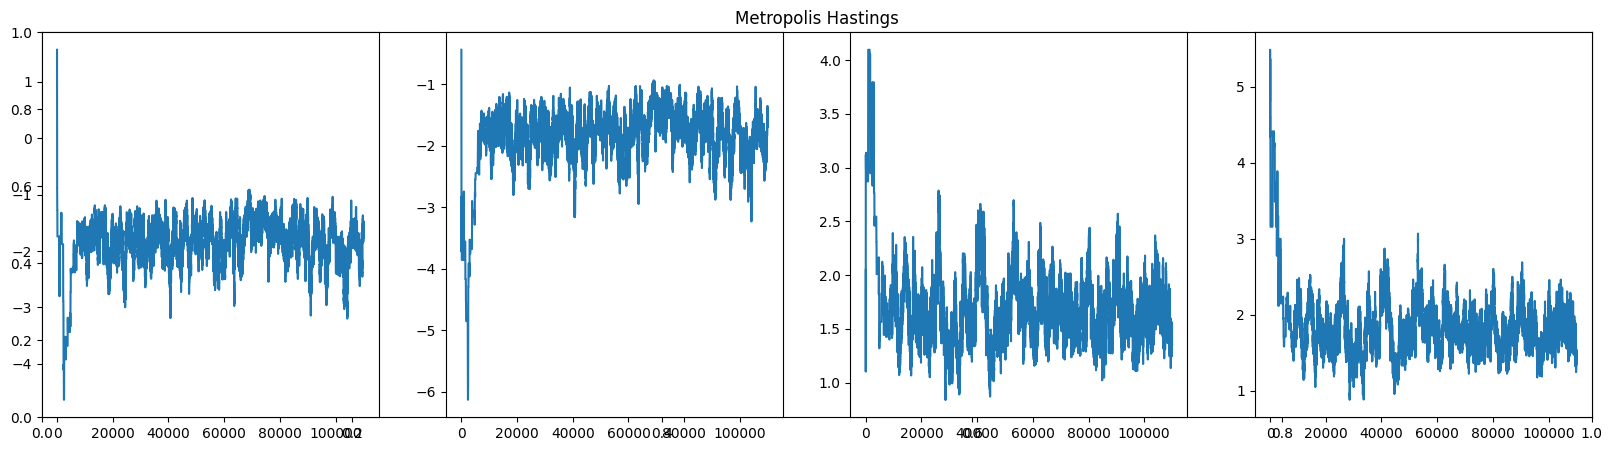

	Acceptance rate:  0.20957272727272727


120it [06:41,  3.34s/it]

	Accuracy:  0.85


In [10]:
run(
    sizes=sizes_xor,
    activations=activations_xor,
    X_train=X_noisy_xor_1,
    y_train=Y_noisy_xor_1,
    X_test=X_noisy_xor_1_test,
    y_test=Y_noisy_xor_1_test,
    N_steps=110_000,
    N_burnin=10_000,
    n_params_to_plot=4,
)

#### Dataset 2

In [ ]:
X_noisy_xor_2 = pd.read_csv("../data/noisy_xor/data2/training/x.csv")
Y_noisy_xor_2 = pd.read_csv("../data/noisy_xor/data2/training/y.csv")
X_noisy_xor_2 = X_noisy_xor_2.to_numpy()
Y_noisy_xor_2 = Y_noisy_xor_2.to_numpy(dtype=int).flatten()
X_noisy_xor_2_test = pd.read_csv("../data/noisy_xor/data2/test/x.csv")
Y_noisy_xor_2_test = pd.read_csv("../data/noisy_xor/data2/test/y.csv")
X_noisy_xor_2_test = X_noisy_xor_2_test.to_numpy()
Y_noisy_xor_2_test = Y_noisy_xor_2_test.to_numpy(dtype=int).flatten()

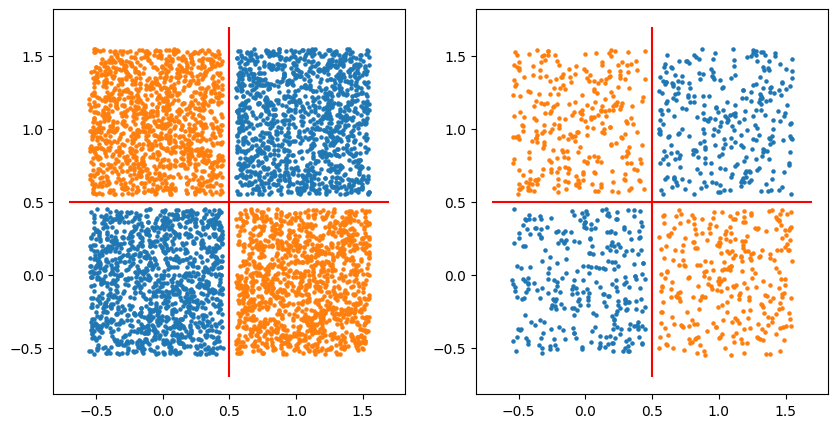

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_noisy_xor_2[Y_noisy_xor_2==0, 0], X_noisy_xor_2[Y_noisy_xor_2==0, 1], s=5)
plt.scatter(X_noisy_xor_2[Y_noisy_xor_2==1, 0], X_noisy_xor_2[Y_noisy_xor_2==1, 1], s=5)
plt.vlines(x=0.5, ymin=-0.7, ymax=1.7, color="r")
plt.hlines(y=0.5, xmin=-0.7, xmax=1.7, color="r")

plt.subplot(1, 2, 2)
plt.scatter(X_noisy_xor_2_test[Y_noisy_xor_2_test==0, 0], X_noisy_xor_2_test[Y_noisy_xor_2_test==0, 1], s=5)
plt.scatter(X_noisy_xor_2_test[Y_noisy_xor_2_test==1, 0], X_noisy_xor_2_test[Y_noisy_xor_2_test==1, 1], s=5)
plt.vlines(x=0.5, ymin=-0.7, ymax=1.7, color="r")
plt.hlines(y=0.5, xmin=-0.7, xmax=1.7, color="r")

plt.show()

In [ ]:
run(
    sizes=sizes_xor,
    activations=activations_xor,
    X_train=X_noisy_xor_2,
    y_train=Y_noisy_xor_2,
    X_test=X_noisy_xor_2_test,
    y_test=Y_noisy_xor_2_test,
    N_steps=110_000,
    N_burnin=10_000,
    verbose=False,
    n_params_to_plot=4,
)

### Pima

#### Dataset 1

In [14]:
X_pima_1 = pd.read_csv("../data/pima/data1/x.csv")
Y_pima_1 = pd.read_csv("../data/pima/data1/y.csv")
X_pima_1 = X_pima_1.to_numpy()
Y_pima_1 = Y_pima_1.to_numpy(dtype=int).flatten()
X_pima_1, X_pima_1_test, Y_pima_1, Y_pima_1_test = train_test_split(X_pima_1, Y_pima_1, test_size=0.4)

Model(
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=2, bias=True)
    (1-2): 2 x Linear(in_features=2, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)
========================================== Prior Sampling ==========================================


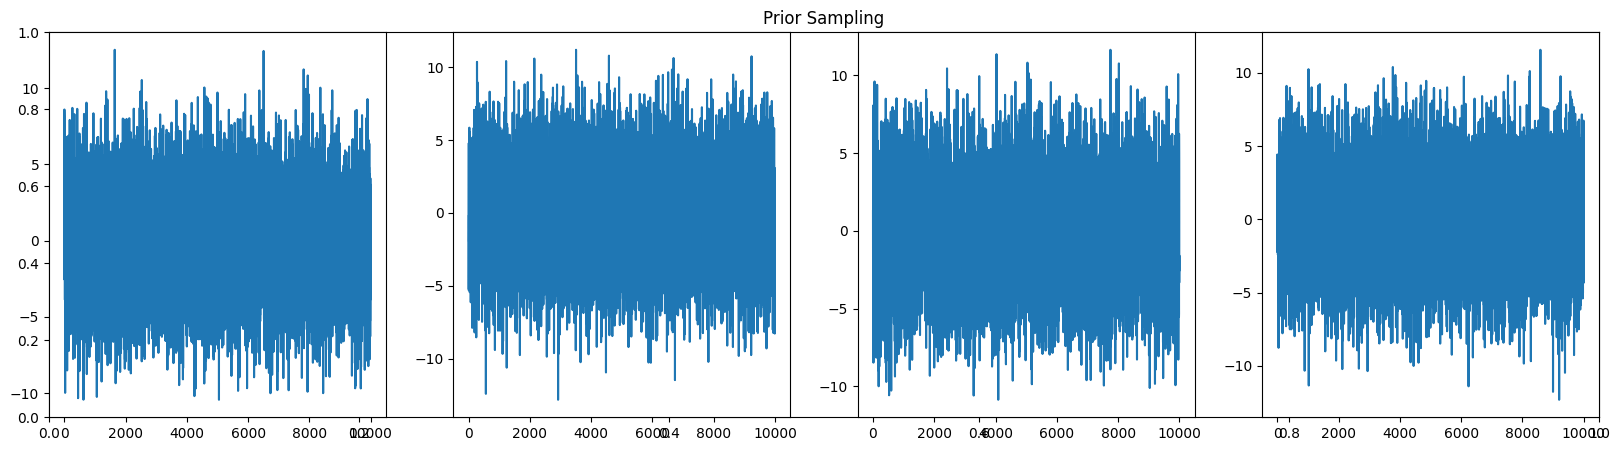

157it [10:13,  3.91s/it]


	Accuracy:  0.6496815286624203
===================================== Hamiltonian Monte Carlo ======================================


100%|██████████| 110000/110000 [13:03<00:00, 140.39it/s]


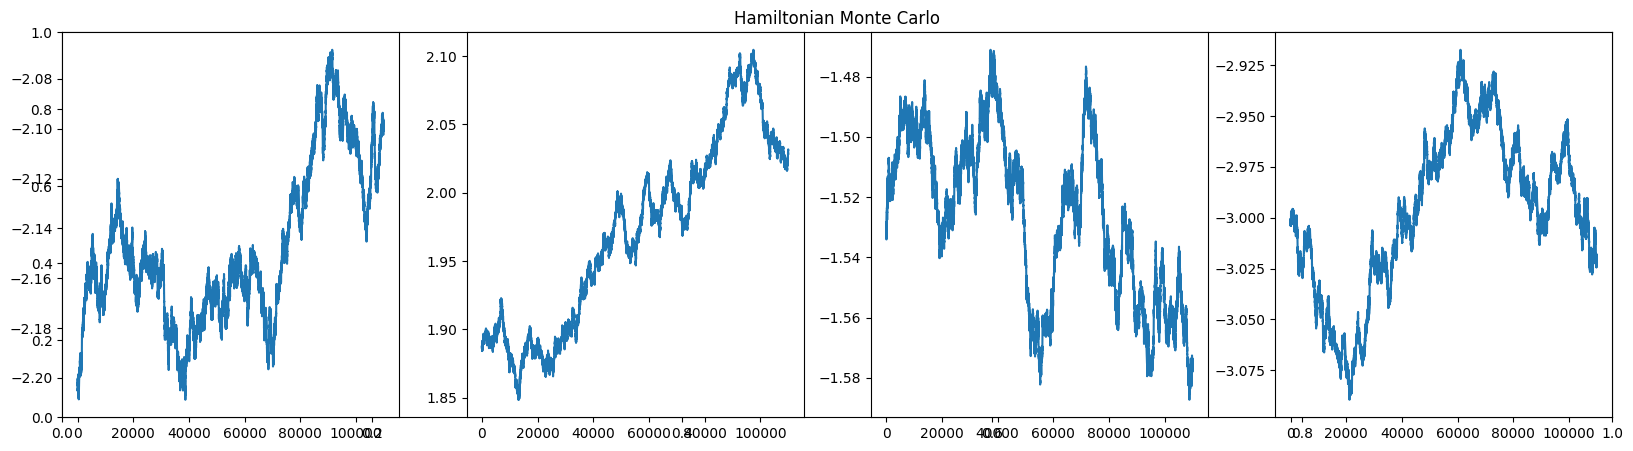

	Acceptance rate:  0.6868272727272727


157it [10:02,  3.84s/it]


	Accuracy:  0.6496815286624203
========================================== Adapative MALA ==========================================


100%|██████████| 110000/110000 [04:01<00:00, 455.29it/s]


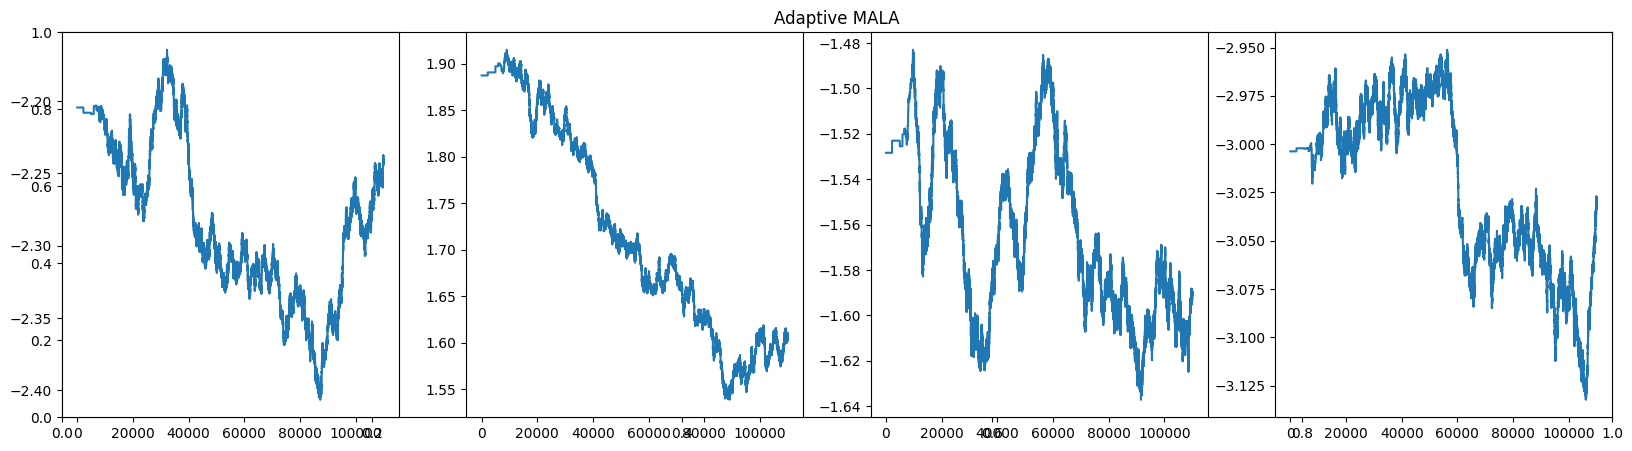

	Acceptance rate:  0.48406363636363636


157it [09:57,  3.80s/it]


	Accuracy:  0.6496815286624203
=============================================== MALA ===============================================
Running MALA sampler...


100%|██████████| 110000/110000 [05:05<00:00, 360.47it/s]


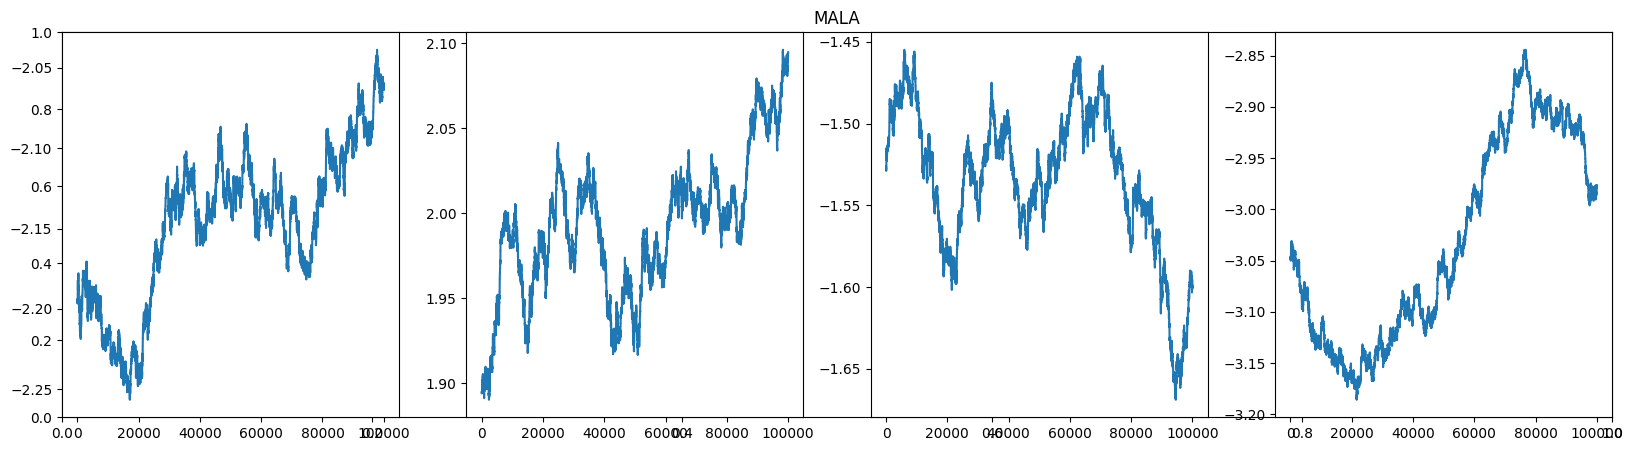

	Acceptance rate:  0.07809090909090909


157it [00:00, 1843.38it/s]


	Accuracy:  0.6496815286624203
============================ Symmetric Random Walk Metropolis Hastings =============================


100%|██████████| 110000/110000 [02:00<00:00, 914.79it/s]


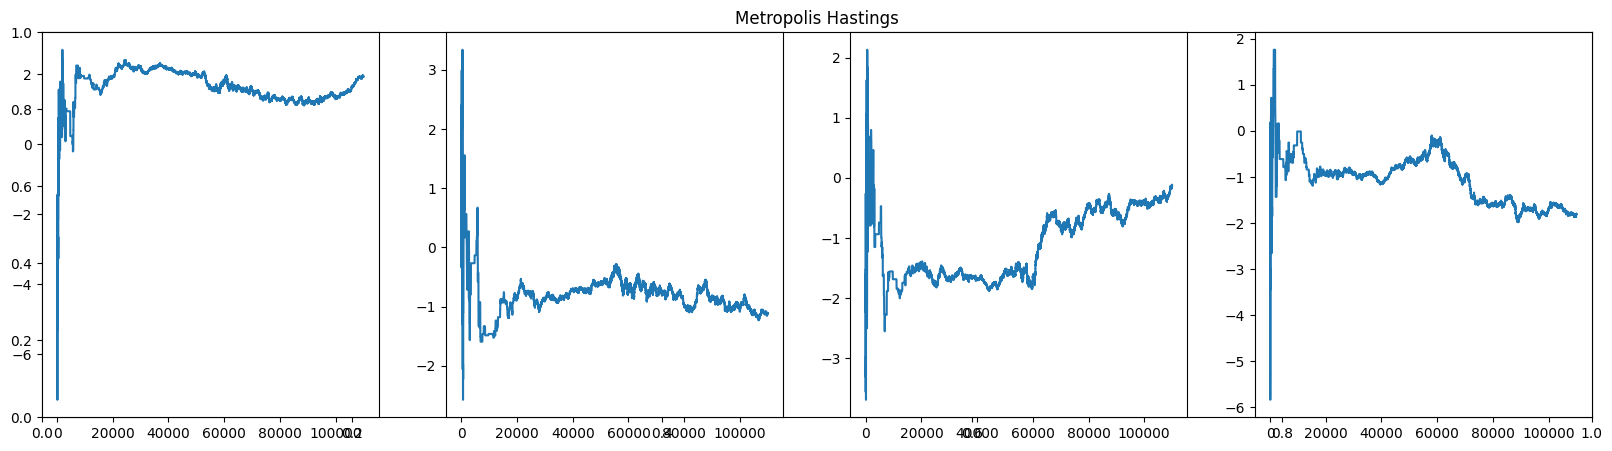

	Acceptance rate:  0.1744090909090909


157it [10:14,  3.92s/it]

	Accuracy:  0.6496815286624203


In [15]:
run(
    sizes=[8, 2, 2, 2],
    activations=[nn.ReLU()] * 3 + [None],
    X_train=X_pima_1,
    y_train=Y_pima_1,
    X_test=X_pima_1_test,
    y_test=Y_pima_1_test,
    N_steps=110_000,
    N_burnin=10_000,
    verbose=False,
    n_params_to_plot=4,
)

#### Dataset 2

In [ ]:
X_pima_2 = pd.read_csv("../data/pima/data2/x.csv")
Y_pima_2 = pd.read_csv("../data/pima/data2/y.csv")
X_pima_2 = X_pima_2.to_numpy()
Y_pima_2 = Y_pima_2.to_numpy(dtype=int).flatten()
X_pima_2, X_pima_2_test, Y_pima_2, Y_pima_2_test = train_test_split(X_pima_2, Y_pima_2, test_size=0.2)

Model(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1-2): 2 x Linear(in_features=2, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)
========================================Metropolis Hastings=========================================


100%|██████████| 100000/100000 [00:38<00:00, 2597.17it/s]
/var/folders/94/mh6g2gbj3bl342zd3jjfff0c0000gn/T/ipykernel_12920/2500159316.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_lines, n_columns, i+1)


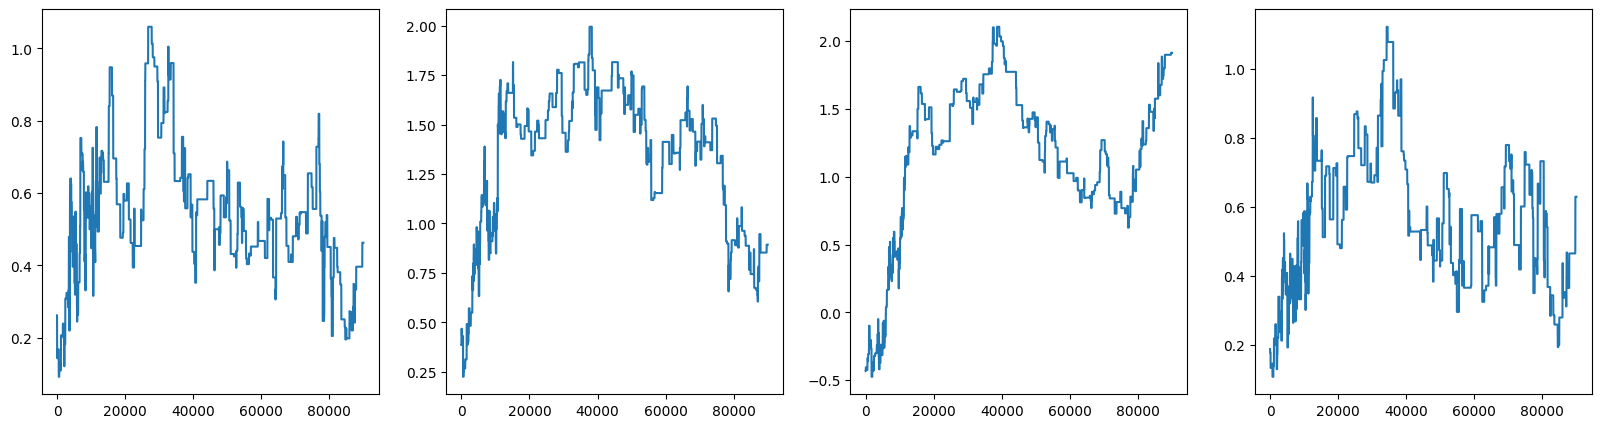

	Acceptance rate:  0.00632


151it [30:09, 11.98s/it]


	Accuracy:  0.7549668874172185
================================================MALA================================================
Running MALA sampler...


100%|██████████| 100000/100000 [01:35<00:00, 1050.73it/s]
/var/folders/94/mh6g2gbj3bl342zd3jjfff0c0000gn/T/ipykernel_12920/2500159316.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_lines, n_columns, i+1)


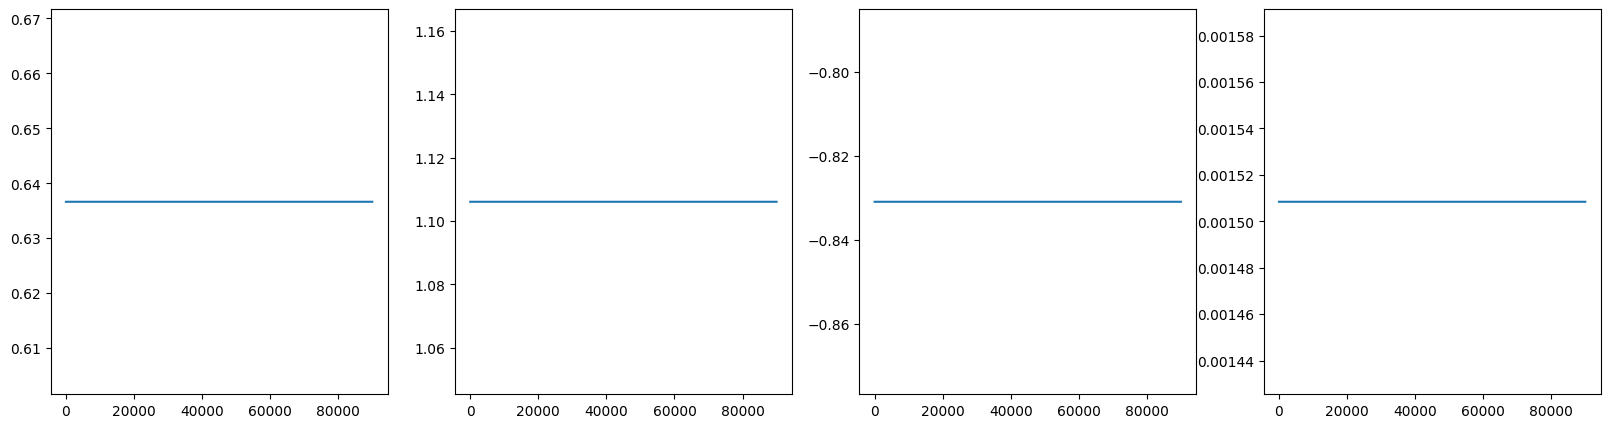

	Acceptance rate:  0.0


151it [29:57, 11.90s/it]


	Accuracy:  0.6821192052980133


In [ ]:
run(
    sizes=[4, 2, 2, 2],
    activations=[nn.ReLU()] * 3 + [None],
    X_train=X_pima_2,
    y_train=Y_pima_2,
    X_test=X_pima_2_test,
    y_test=Y_pima_2_test,
    N_steps=110_000,
    N_burnin=10_000,
    verbose=False,
    n_params_to_plot=4,
)

### Penguins

In [16]:
X_penguins = pd.read_csv("../data/penguins/x.csv")
X_penguins.drop(columns="year", inplace=True)
Y_penguins = pd.read_csv("../data/penguins/y.csv")
X_penguins = X_penguins.to_numpy()
Y_penguins = Y_penguins.to_numpy(dtype=int).flatten()
X_penguins, X_penguins_test, Y_penguins, Y_penguins_test = train_test_split(X_penguins, Y_penguins, test_size=0.2)

Model(
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
  (loss): CrossEntropyLoss()
)
========================================== Prior Sampling ==========================================


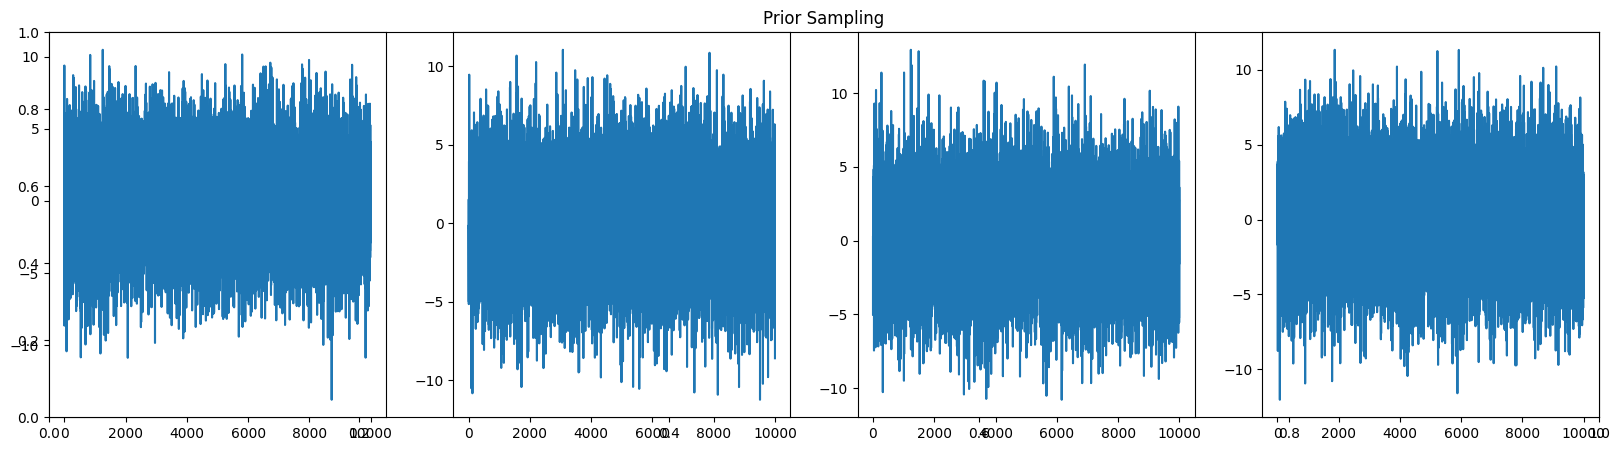

67it [16:15, 14.56s/it]


	Accuracy:  0.2537313432835821
===================================== Hamiltonian Monte Carlo ======================================


100%|██████████| 110000/110000 [24:37<00:00, 74.47it/s] 


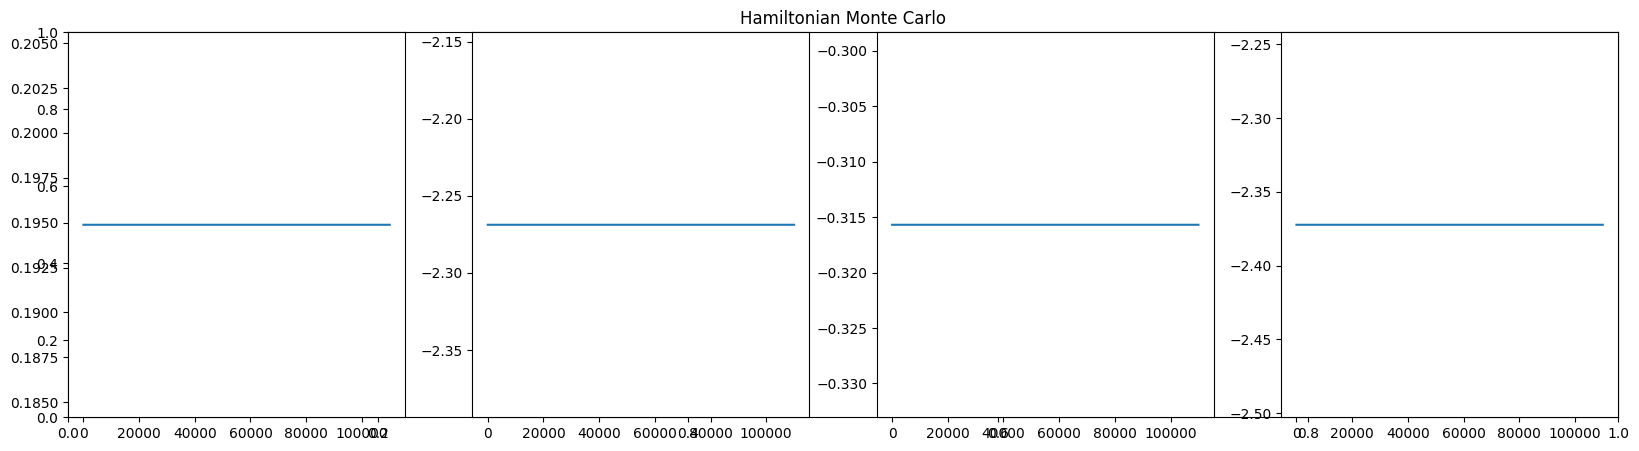

	Acceptance rate:  0.0


0it [00:00, ?it/s]

In [18]:
run(
    sizes=[6, 2, 2, 3],
    activations=[nn.ReLU()] * 3 + [None],
    X_train=X_penguins,
    y_train=Y_penguins,
    X_test=X_penguins_test,
    y_test=Y_penguins_test,
    N_steps=110_000,
    N_burnin=10_000,
    verbose=False,
    n_params_to_plot=4,
    hmc_params=dict(step_size=0.000004, n_leapfrog=10),
)

### Hawks

In [ ]:
X_hawks = pd.read_csv("../data/hawks/x.csv")
Y_hawks = pd.read_csv("../data/hawks/y.csv")
X_hawks = X_hawks.to_numpy()
Y_hawks = Y_hawks.to_numpy(dtype=int).flatten()
X_hawks, X_hawks_test, Y_hawks, Y_hawks_test = train_test_split(X_hawks, Y_hawks, test_size=0.2)

Model(
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
  (loss): CrossEntropyLoss()
)
========================================Metropolis Hastings=========================================


100%|██████████| 100000/100000 [00:33<00:00, 3014.15it/s]
/var/folders/94/mh6g2gbj3bl342zd3jjfff0c0000gn/T/ipykernel_12920/2500159316.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_lines, n_columns, i+1)


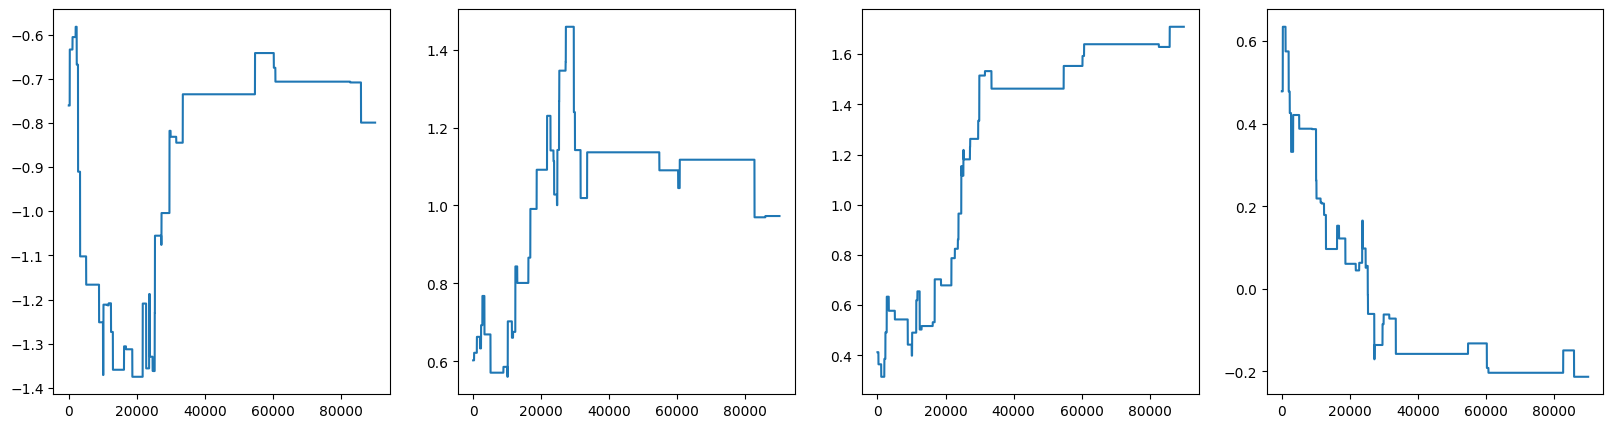

	Acceptance rate:  0.00668


67it [39:47, 35.63s/it]


	Accuracy:  0.9253731343283582
================================================MALA================================================
Running MALA sampler...


100%|██████████| 100000/100000 [01:22<00:00, 1210.91it/s]
/var/folders/94/mh6g2gbj3bl342zd3jjfff0c0000gn/T/ipykernel_12920/2500159316.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_lines, n_columns, i+1)


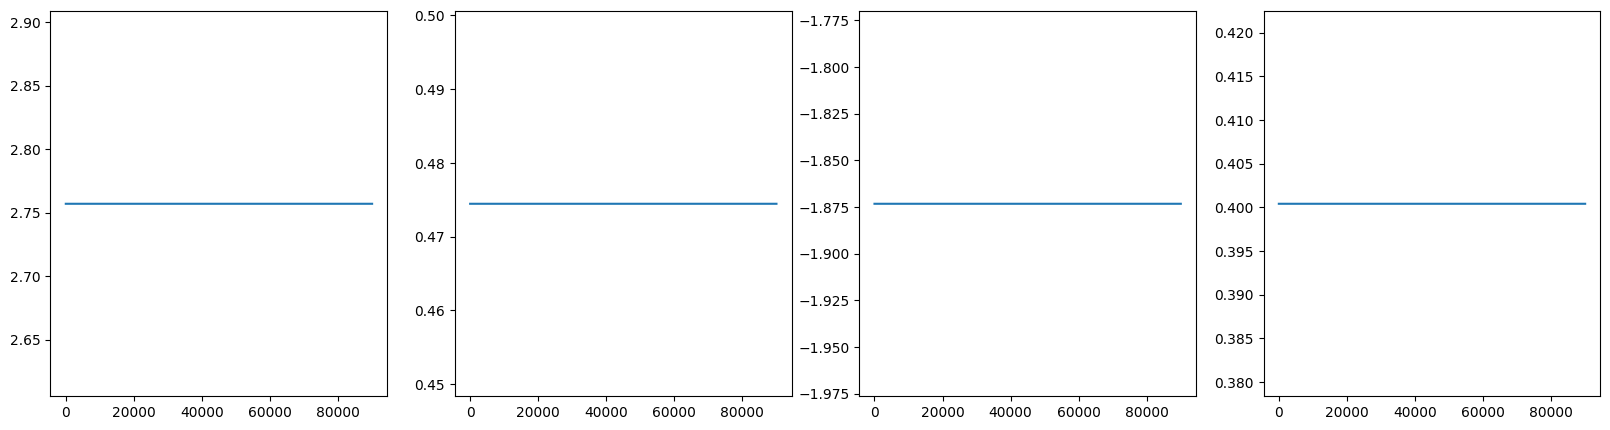

	Acceptance rate:  0.0


67it [45:59, 41.19s/it]


	Accuracy:  0.34328358208955223


In [ ]:
run(
    sizes=[6, 2, 2, 3],
    activations=[nn.ReLU()] * 3 + [None],
    X_train=X_penguins,
    y_train=Y_penguins,
    X_test=X_penguins_test,
    y_test=Y_penguins_test,
    N_steps=110_000,
    N_burnin=10_000,
    verbose=False,
    n_params_to_plot=4,
)